In [1]:
import re
import sys

import time
import datetime

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import random


In [2]:
data = pd.read_csv('Google-Playstore-32K.csv', delimiter=',')
data.dataframeName = 'Google-Playstore-32K.csv'
nRow, nCol = data.shape
print(f'There are {nRow} rows and {nCol} columns')


There are 32000 rows and 11 columns


In [3]:
data = data.sort_values('Installs', ascending=False)
data = data.drop_duplicates(subset='App Name', keep='first')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30845 entries, 6941 to 24784
Data columns (total 11 columns):
App Name           30845 non-null object
Category           30845 non-null object
Rating             30845 non-null object
Reviews            30844 non-null float64
Installs           30845 non-null object
Size               30845 non-null object
Price              30845 non-null object
Content Rating     30845 non-null object
Last Updated       30845 non-null object
Minimum Version    30845 non-null object
Latest Version     30844 non-null object
dtypes: float64(1), object(10)
memory usage: 2.8+ MB


In [4]:
#detect null cols and null rate
nulls = [i for i in data.isna().any().index if data.isna().any()[i]==True]
rates = []
counts = []
for i in nulls:    
    rates.append((data[i].isna().sum()/data.shape[0])*100)
    counts.append(data[i].isna().sum())
null_df = pd.DataFrame.from_dict({"Col":nulls,"Count":counts,"Null_Rates":rates})
null_df

,Col,Count,Null_Rates
0,Reviews,1,0.003242
1,Latest Version,1,0.003242


In [5]:
#delete Type,Content Rating, Current Ver, Android Ver null values row
df_train = data.copy()
for i in ['Reviews','Latest Version']:
    df_train = df_train.drop(df_train.loc[df_train[i].isnull()].index,0)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30843 entries, 13504 to 24784
Data columns (total 11 columns):
App Name           30843 non-null object
Category           30843 non-null object
Rating             30843 non-null object
Reviews            30843 non-null float64
Installs           30843 non-null object
Size               30843 non-null object
Price              30843 non-null object
Content Rating     30843 non-null object
Last Updated       30843 non-null object
Minimum Version    30843 non-null object
Latest Version     30843 non-null object
dtypes: float64(1), object(10)
memory usage: 2.8+ MB


In [6]:
df_train['Rating'].replace('Lessons', np.nan, inplace=True)
df_train['Rating'].replace('GAME_STRATEGY', np.nan, inplace=True)
df_train['Rating'].replace('NEWS_AND_MAGAZINES', np.nan, inplace=True)
df_train['Rating'] = df_train['Rating'].fillna(df_train['Rating'].median())

# for i in ['Rating']:
#     df_train = df_train.drop(df_train.loc[df_train[i].isnull()].index,0)
df_train['Rating'].astype(float).describe()

count    30843.000000
mean         4.268535
std          0.501046
min          1.000000
25%          4.086957
50%          4.373173
75%          4.581750
max          5.000000
Name: Rating, dtype: float64

In [7]:
df_train['Installs'] = df_train['Installs'].apply(lambda x : x.strip('+').replace(',', ''))
df_train.Installs.unique()


array(['6', '500000000', '500000', '500', '50000000', '50000', '50',
       '5000000000', '5000000', '5000', '5', '11976', '100000000',
       '100000', '100', '10000000', '10000', '10', '1000000000',
       '1000000', '1000', '1', '0'], dtype=object)

In [8]:
len(df_train.Category.unique())

51

In [9]:

regex = [r'GAME_[A-Za-z]+.*']
for j in regex:
    df_train['Category'] = df_train['Category'].astype(str).apply(lambda x : re.sub(j, 'GAME', x))

In [10]:
df_train.Category.unique()

array([')', 'HEALTH_AND_FITNESS', 'PRODUCTIVITY', 'GAME', 'ENTERTAINMENT',
       'TOOLS', 'COMMUNICATION', 'NEWS_AND_MAGAZINES', 'VIDEO_PLAYERS',
       'SOCIAL', 'WEATHER', 'LIFESTYLE', 'MAPS_AND_NAVIGATION',
       'EDUCATION', 'PERSONALIZATION', 'SHOPPING', 'TRAVEL_AND_LOCAL',
       'FINANCE', 'SPORTS', 'BOOKS_AND_REFERENCE', 'MUSIC_AND_AUDIO',
       'FOOD_AND_DRINK', 'MEDICAL', 'BUSINESS', 'AUTO_AND_VEHICLES',
       'PHOTOGRAPHY', 'BEAUTY', 'HOUSE_AND_HOME', 'PARENTING', 'COMICS',
       'EVENTS', 'DATING', 'LIBRARIES_AND_DEMO', 'ART_AND_DESIGN',
       ' Channel 2 News'], dtype=object)

In [11]:
regex = [r'[-+|/:/;(_)@\[\]#�,>]', r'\s+', r'[A-Za-z]+']
for j in regex:
    df_train['Latest Version'] = df_train['Latest Version'].astype(str).apply(lambda x : re.sub(j, '0', x))
df_train['Latest Version'].replace('?.?', np.nan, inplace=True)

df_train['Latest Version'] = df_train['Latest Version'].astype(str).apply(lambda x : x.replace('.', ',',1).replace('.', '').replace(',', '.',1)[:3]).astype(float)
df_train['Latest Version'] = df_train['Latest Version'].fillna(df_train['Latest Version'].median())


In [12]:
df_train['Latest Version'].unique()

array([4.00e+00, 6.20e+00, 0.00e+00, 1.40e+00, 5.20e+00, 2.10e+00,
       1.36e+02, 1.00e+01, 3.10e+00, 4.90e+00, 1.20e+01, 1.10e+00,
       9.40e+00, 1.50e+00, 4.10e+00, 1.10e+01, 1.50e+01, 1.00e+00,
       4.70e+00, 4.30e+00, 1.60e+00, 1.30e+00, 5.10e+00, 1.20e+00,
       3.20e+00, 7.20e+00, 1.70e+00, 1.00e-01, 3.90e+00, 2.30e+00,
       9.20e+00, 3.30e+00, 1.90e+00, 2.40e+00, 1.80e+00, 4.20e+00,
       2.70e+00, 2.20e+00, 6.10e+00, 2.00e+00, 1.30e+01, 2.01e+02,
       5.50e+00, 4.00e+01, 4.60e+00, 6.30e+00, 3.70e+00, 3.00e+00,
       2.50e+00, 2.90e+00, 3.40e+00, 2.80e+00, 5.80e+00, 3.50e+00,
       5.00e-01, 2.60e+00, 2.50e+01, 4.50e+00, 4.60e+01, 2.10e+01,
       1.90e+01, 8.30e+00, 7.00e+00, 8.93e+02, 5.00e+00, 4.40e+00,
       3.80e+00, 7.60e+00, 2.00e-01, 3.60e+00, 9.90e+00, 3.10e+02,
       8.10e+00, 6.00e+00, 5.70e+00, 5.90e+00, 8.00e+00, 7.10e+00,
       6.60e+00, 7.30e+00, 6.80e+00, 7.50e+00, 2.73e+02, 5.30e+00,
       7.00e-01, 1.40e+01, 9.10e+00, 1.70e+01, 5.60e+00, 6.70e

In [13]:
df_train

,App Name,Category,Rating,Reviews,Installs,Size,Price,Content Rating,Last Updated,Minimum Version,Latest Version
13504,Never have I ever 18+,),4.37317,4.0,6,100+,2.4M,$0.99,Mature 17+,"December 30, 2018",4.0
20981,Samsung Health,HEALTH_AND_FITNESS,4.320483208,667452.0,500000000,79M,0,Everyone,"March 27, 2019",5.0 and up,6.2
6747,Super-Bright LED Flashlight,PRODUCTIVITY,4.596871376,9123436.0,500000000,Varies with device,0,Everyone,"March 27, 2019",Varies with device,0.0
420,Google Docs,PRODUCTIVITY,4.351906776,987137.0,500000000,Varies with device,0,Everyone,"April 1, 2019",Varies with device,0.0
820,Pou,GAME,4.330340385,10752323.0,500000000,24M,0,Everyone,"May 25, 2018",4.0 and up,1.4
...,...,...,...,...,...,...,...,...,...,...,...
11503,Spell & Play: Vehicles,GAME,5,1.0,1,44M,$0.99,Everyone,"March 24, 2019",4.0 and up,1.0
4854,Grow your childrens intelligence,GAME,5,1.0,1,23M,0,Everyone,"March 6, 2019",4.1 and up,14.0
2916,Spell & Play: Fish Friends,GAME,5,2.0,1,45M,$0.99,Everyone,"March 24, 2019",4.0 and up,1.0
25708,Magic Room,ENTERTAINMENT,5,1.0,1,27M,$0.99,Everyone,"March 6, 2019",5.0 and up,1.9


In [14]:
df_train['Category'].replace(' Channel 2 News', np.nan, inplace=True)
df_train['Category'].replace(')', np.nan, inplace=True)
df_train = df_train[pd.notnull(df_train['Category'])]

df_train.to_csv("preprocessed.csv")

In [15]:
# App values encoding
le = preprocessing.LabelEncoder()
df_train['App Name'] = le.fit_transform(df_train['App Name'])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
df_train

,App Name,Category,Rating,Reviews,Installs,Size,Price,Content Rating,Last Updated,Minimum Version,Latest Version
20981,23361,HEALTH_AND_FITNESS,4.320483208,667452.0,500000000,79M,0,Everyone,"March 27, 2019",5.0 and up,6.2
6747,25647,PRODUCTIVITY,4.596871376,9123436.0,500000000,Varies with device,0,Everyone,"March 27, 2019",Varies with device,0.0
420,12047,PRODUCTIVITY,4.351906776,987137.0,500000000,Varies with device,0,Everyone,"April 1, 2019",Varies with device,0.0
820,21264,GAME,4.330340385,10752323.0,500000000,24M,0,Everyone,"May 25, 2018",4.0 and up,1.4
304,19025,ENTERTAINMENT,4.448670864,6385467.0,500000000,Varies with device,0,Teen,"March 29, 2019",Varies with device,0.0
...,...,...,...,...,...,...,...,...,...,...,...
11503,24896,GAME,5,1.0,1,44M,$0.99,Everyone,"March 24, 2019",4.0 and up,1.0
4854,12225,GAME,5,1.0,1,23M,0,Everyone,"March 6, 2019",4.1 and up,14.0
2916,24892,GAME,5,2.0,1,45M,$0.99,Everyone,"March 24, 2019",4.0 and up,1.0
25708,16706,ENTERTAINMENT,5,1.0,1,27M,$0.99,Everyone,"March 6, 2019",5.0 and up,1.9


In [17]:
# Category features encoding
# category_list = df_train['Category'].unique().tolist() 
# category_list = ['cat_' + word for word in category_list]
# df_train = pd.concat([df_train, pd.get_dummies(df_train['Category'], prefix='cat')], axis=1)
# Encode Content Rating features
le2 = preprocessing.LabelEncoder()
df_train['Category'] = le2.fit_transform(df_train['Category'])

df_train

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,App Name,Category,Rating,Reviews,Installs,Size,Price,Content Rating,Last Updated,Minimum Version,Latest Version
20981,23361,14,4.320483208,667452.0,500000000,79M,0,Everyone,"March 27, 2019",5.0 and up,6.2
6747,25647,25,4.596871376,9123436.0,500000000,Varies with device,0,Everyone,"March 27, 2019",Varies with device,0.0
420,12047,25,4.351906776,987137.0,500000000,Varies with device,0,Everyone,"April 1, 2019",Varies with device,0.0
820,21264,13,4.330340385,10752323.0,500000000,24M,0,Everyone,"May 25, 2018",4.0 and up,1.4
304,19025,9,4.448670864,6385467.0,500000000,Varies with device,0,Teen,"March 29, 2019",Varies with device,0.0
...,...,...,...,...,...,...,...,...,...,...,...
11503,24896,13,5,1.0,1,44M,$0.99,Everyone,"March 24, 2019",4.0 and up,1.0
4854,12225,13,5,1.0,1,23M,0,Everyone,"March 6, 2019",4.1 and up,14.0
2916,24892,13,5,2.0,1,45M,$0.99,Everyone,"March 24, 2019",4.0 and up,1.0
25708,16706,9,5,1.0,1,27M,$0.99,Everyone,"March 6, 2019",5.0 and up,1.9


In [18]:
# Encode Content Rating features
le = preprocessing.LabelEncoder()
df_train['Content Rating'] = le.fit_transform(df_train['Content Rating'])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
# Price cealning
df_train['Price'] = df_train['Price'].apply(lambda x : x.strip('$'))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [20]:
df_train.Price.unique()

array(['0', '1.99', '0.99', '4.99', '6.99', '2.99', '9.99', '3.75',
       '3.99', '2.49', '2.79', '7.99', '5.99', '14.99', '4.49', '4.95',
       '1.49', '3.85', '15.99', '12.99', '24.99', '6.49', '5.49', '3.00',
       '29.99', '3.49', '7.49', '84.99', '9.49', '39.99', '6.00', '8.99',
       '1.00', '12.00', '2.00', '2.50', '5.00', '5.74', '4.69', '11.99',
       '8.80', '1.20', '8.49', '54.99', '10.75', '1.40', '18.60', '5.78',
       '19.99', '2.40', '5.33', '3.22', '4.89', '10.99', '1.19', '4.00',
       '1.97', '3.29', '9.00', '2.20', '3.95', '1.29', '13.99', '14.01',
       '1.26', '14.93', '32.99', '1.09', '22.99', '9.79', '1.50', '1.80',
       '5.76', '14.73', '45.99', '9.95', '3.81', '10.00', '3.55', '1.25',
       '6.71', '1.90', '27.99', '1.59', '74.99', '7.74', '6.30', '23.99',
       '2.90', '1.05', '399.99', '6.29', '31.99', '79.99', '21.00',
       '34.99', '99.99', '2.59', '17.99', '4.50', '299.99'], dtype=object)

In [21]:
df_train['Price'].replace('Varies with device', np.nan, inplace=True)
df_train['Price'] = df_train['Price'].fillna(df_train['Price'].median())


/Users/gaganpree99/Library/Python/3.7/lib/python/site-packages/pandas/core/generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
df_train['Type'] = np.where(df_train['Price'].astype(float) > 0, 'Paid', 'Free')
df_train

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,App Name,Category,Rating,Reviews,Installs,Size,Price,Content Rating,Last Updated,Minimum Version,Latest Version,Type
20981,23361,14,4.320483208,667452.0,500000000,79M,0,1,"March 27, 2019",5.0 and up,6.2,Free
6747,25647,25,4.596871376,9123436.0,500000000,Varies with device,0,1,"March 27, 2019",Varies with device,0.0,Free
420,12047,25,4.351906776,987137.0,500000000,Varies with device,0,1,"April 1, 2019",Varies with device,0.0,Free
820,21264,13,4.330340385,10752323.0,500000000,24M,0,1,"May 25, 2018",4.0 and up,1.4,Free
304,19025,9,4.448670864,6385467.0,500000000,Varies with device,0,4,"March 29, 2019",Varies with device,0.0,Free
...,...,...,...,...,...,...,...,...,...,...,...,...
11503,24896,13,5,1.0,1,44M,0.99,1,"March 24, 2019",4.0 and up,1.0,Paid
4854,12225,13,5,1.0,1,23M,0,1,"March 6, 2019",4.1 and up,14.0,Free
2916,24892,13,5,2.0,1,45M,0.99,1,"March 24, 2019",4.0 and up,1.0,Paid
25708,16706,9,5,1.0,1,27M,0.99,1,"March 6, 2019",5.0 and up,1.9,Paid


In [23]:
# Type encoding
types = preprocessing.LabelEncoder()
df_train['Type'] = types.fit_transform(df_train['Type'])

# df_train['Type'] = pd.get_dummies(df_train['Type'])


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
df_train['Last Updated'].replace('Everyone 10+', np.nan, inplace=True)
df_train = df_train[pd.notnull(df_train['Last Updated'])]

df_train['Last Updated'] = df_train['Last Updated'].apply(lambda x : time.mktime(datetime.datetime.strptime(x, '%B %d, %Y').timetuple()))


In [25]:
# regex = [r',']
# for j in regex:
#     df_train['Size'] = df_train['Size'].astype(str).apply(lambda x : re.sub(j, '', x))
    
# # Convert kbytes to Mbytes 
# k_indices = df_train['Size'].loc[df_train['Size'].str.contains('k')].index.tolist()
# converter = pd.DataFrame(df_train.loc[k_indices, 'Size'].apply(lambda x: x.strip('k')).astype(float).apply(lambda x: x / 1024).apply(lambda x: round(x, 3)).astype(str))
# df_train.loc[k_indices,'Size'] = converter


# df_train['Size'] = df_train['Size'].apply(lambda x: x.strip('M'))
# df_train.loc[df_train['Size'] == 'Varies with device', 'Size'] = 0
# # df_train[df_train['Size'] == 'Varies with device','Size'] = 0
# df_train['Size'] = df_train['Size'].astype(float)


regex = [r',']
for j in regex:
    df_train['Size'] = df_train['Size'].astype(str).apply(lambda x : re.sub(j, '', x))
    
# Convert kbytes to Mbytes 
k_indices = df_train['Size'].loc[df_train['Size'].str.contains('k')].index.tolist()
converter = pd.DataFrame(df_train.loc[k_indices, 'Size'].apply(lambda x: x.strip('k')).astype(float).apply(lambda x: x / 1024).apply(lambda x: round(x, 3)).astype(str))
df_train.loc[k_indices,'Size'] = converter

# Size cleaning
df_train['Size'] = df_train['Size'].apply(lambda x: x.strip('M'))
df_train[df_train['Size'] == 'Varies with device'] = 0
df_train['Size'] = df_train['Size'].astype(float)


In [26]:
regex = [r'[-+|/:/;(_)@\[\]#�,>]', r'\s+', r'[A-Za-z]+']
for j in regex:
    df_train['Minimum Version'] = df_train['Minimum Version'].astype(str).apply(lambda x : re.sub(j, '0', x))

df_train['Minimum Version'] = df_train['Minimum Version'].astype(str).apply(lambda x : x.replace('.', ',',1).replace('.', '').replace(',', '.',1)[:3]).astype(float)
df_train['Minimum Version'] = df_train['Minimum Version'].fillna(df_train['Minimum Version'].median())


In [27]:
df_train['Installs'].unique()

array(['500000000', 0, '500000', '500', '50000000', '50000', '50',
       '5000000', '5000', '5', '100000000', '100000', '100', '10000000',
       '10000', '10', '1000000000', '1000000', '1000', '1', '0'],
      dtype=object)

In [28]:
df_train['Reviews'].describe()

count    3.084100e+04
mean     5.966535e+04
std      6.300812e+05
min      0.000000e+00
25%      4.000000e+01
50%      6.910000e+02
75%      7.906000e+03
max      4.840147e+07
Name: Reviews, dtype: float64

In [29]:
df_train['Price'] = df_train['Price'].astype(float)
df_train['Rating'] = df_train['Rating'].astype(float)
df_train['Reviews'] = df_train['Reviews'].astype(int)
df_train['Last Updated'] = df_train['Last Updated'].astype(float)

In [30]:
# df_train['Installs'].replace(0, np.nan, inplace=True)
# df_train = df_train[pd.notnull(df_train['Installs'])]
install = preprocessing.LabelEncoder()
df_train['Installs'] = df_train['Installs'].astype(int)
df_train['Installs'] = install.fit_transform(df_train['Installs'])


In [31]:
df_train

,App Name,Category,Rating,Reviews,Installs,Size,Price,Content Rating,Last Updated,Minimum Version,Latest Version,Type
20981,23361,14,4.320483,667452,18,79.0,0.00,1,1.553656e+09,5.0,6.2,0
6747,0,0,0.000000,0,0,0.0,0.00,0,0.000000e+00,0.0,0.0,0
420,0,0,0.000000,0,0,0.0,0.00,0,0.000000e+00,0.0,0.0,0
820,21264,13,4.330340,10752323,18,24.0,0.00,1,1.527217e+09,4.0,1.4,0
304,0,0,0.000000,0,0,0.0,0.00,0,0.000000e+00,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11503,24896,13,5.000000,1,1,44.0,0.99,1,1.553396e+09,4.0,1.0,1
4854,12225,13,5.000000,1,1,23.0,0.00,1,1.551845e+09,4.1,14.0,0
2916,24892,13,5.000000,2,1,45.0,0.99,1,1.553396e+09,4.0,1.0,1
25708,16706,9,5.000000,1,1,27.0,0.99,1,1.551845e+09,5.0,1.9,1


---

# Predict Rating

In [212]:
# Split data into training and testing sets
features = [ 'Size', 'Type', 'Content Rating','Price','Category']
# features.extend(category_list)
X = df_train[features]
y = df_train['Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 10)

model = KNeighborsRegressor(n_neighbors = 15)
model.fit(X_train, y_train)
accuracy = model.score(X_test,y_test)
'Accuracy: ' + str(np.round(accuracy*100, 2)) + '%'

'Accuracy: 87.76%'

In [213]:
import xgboost as xgb

xgbModel = xgb.XGBRegressor()
xgbModel.fit(X_train, y_train)
accuracy = xgbModel.score(X_test,y_test)
'Accuracy: ' + str(np.round(accuracy*100, 2)) + '%'

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:55:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


'Accuracy: 88.35%'

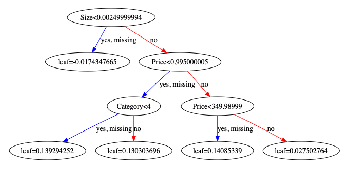

In [214]:
from xgboost import plot_tree

# plot single tree
plot_tree(xgbModel,num_trees=10)
plt.show()

In [215]:
Rating = ''
Installations = ''
Size = '48'
Type = 'Paid'
ContentRating = 'Everyone'
Price = '2.6'
Category = 'GAME'
varySize = False
varyPrice = True

In [216]:
ratingRange = 200
del(dfTest)
dfTest = pd.DataFrame(columns=features)
dataRow = dict({'Size':int(Size), 
                'Type':types.transform([Type])[0], 
                'Content Rating': le.transform([ContentRating])[0], 
                'Price': float(Price), 
                'Category': le2.transform([Category])[0]})

dfTest = dfTest.append(dataRow, ignore_index=True)

if not(varySize^varyPrice):
    predRating = round(xgbModel.predict(dfTest)[0],2)

else:
    if varySize:
        modelRange = np.linspace(0, 2 * int(Size),ratingRange)
        lst_dict = []
        for a in modelRange:
            lst_dict.append({'Size': a, 
                'Type':types.transform([Type])[0], 
                'Content Rating': le.transform([ContentRating])[0], 
                'Price': float(Price), 
                'Category': le2.transform([Category])[0]})
        dfTest = dfTest.append(lst_dict, ignore_index=True)
                
        ratingRange = xgbModel.predict(dfTest)
        predictionRange = dict(zip(dfTest['Size'], predRatingRange))
        
    else:
        modelRange = np.linspace(0, 5 * float(Price),ratingRange)
        lst_dict = []
        for a in modelRange:
            lst_dict.append({'Size': int(Size), 
                'Type':types.transform([Type])[0], 
                'Content Rating': le.transform([ContentRating])[0], 
                'Price': a, 
                'Category': le2.transform([Category])[0]})
        dfTest = dfTest.append(lst_dict, ignore_index=True)
       
        ratingRange = xgbModel.predict(dfTest)
        predictionRange = dict(zip(dfTest['Price'], predRatingRange))


In [217]:
predictionRange

{2.6: 4.358059,
 0.0: 4.30675,
 0.06532663316582915: 4.30675,
 0.1306532663316583: 4.30675,
 0.19597989949748745: 4.30675,
 0.2613065326633166: 4.30675,
 0.32663316582914576: 4.30675,
 0.3919597989949749: 4.30675,
 0.45728643216080406: 4.30675,
 0.5226130653266332: 4.30675,
 0.5879396984924623: 4.30675,
 0.6532663316582915: 4.30675,
 0.7185929648241207: 4.30675,
 0.7839195979899498: 4.30675,
 0.8492462311557789: 4.30675,
 0.9145728643216081: 4.30675,
 0.9798994974874373: 4.30675,
 1.0452261306532664: 4.335763,
 1.1105527638190955: 4.335763,
 1.1758793969849246: 4.335763,
 1.241206030150754: 4.335763,
 1.306532663316583: 4.335763,
 1.3718592964824121: 4.335763,
 1.4371859296482414: 4.335763,
 1.5025125628140705: 4.335763,
 1.5678391959798996: 4.335763,
 1.6331658291457287: 4.335763,
 1.6984924623115578: 4.335763,
 1.7638190954773871: 4.335763,
 1.8291457286432162: 4.335763,
 1.8944723618090453: 4.335763,
 1.9597989949748746: 4.335763,
 2.0251256281407035: 4.335763,
 2.090452261306533: 4

In [218]:
from sklearn.metrics import mean_absolute_error

predicted = xgbModel.predict(X_test)
print("Mean Absolute Error: {0}".format(mean_absolute_error(y_test, predicted)))


Mean Absolute Error: 0.31386782716464234


In [191]:
from sklearn.metrics import r2_score
print("r2_score: {0}".format(r2_score(y_test, predicted)))


r2_score: 0.8835212178823773


### Implement Grid Search to improve performance

In [192]:
# Improving XgBoost Model using GridSearch 
from sklearn.model_selection import GridSearchCV

parameters = {"learning_rate": [0.02, 0.01, 0.03],
               "gamma" : [0,0.5,0.6,0.7],
               "max_depth": [2,6],
               "subsample": [0.5, 0.6, 1],
               "min_child_weight": [1],
               "n_estimators": [ 500, 600, 700]}

xgb_grid = GridSearchCV(xgb.XGBRegressor(),
                        parameters,
                        n_jobs = 5,
                        cv=2,
                        verbose=True)

# grid_result = xgb_grid.fit(X_train, y_train)
grid_result = xgb_grid.fit(X_train[: 10000], y_train[: 10000])
xgb_params = grid_result.best_params_


Fitting 2 folds for each of 216 candidates, totalling 432 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


KeyboardInterrupt: 

In [ ]:
# create a model with the optimised parameters
xgbM = xgb.XGBRegressor(gamma = xgb_params['gamma'],
                        learning_rate = xgb_params['learning_rate'], 
                        max_depth = xgb_params['max_depth'],
                        min_child_weight = xgb_params['min_child_weight'],
                        n_estimators = xgb_params['n_estimators'], 
                        subsample= xgb_params['subsample'], n_jobs = -1)

xgbM.fit(X_train, y_train)
accuracy = xgbM.score(X_test,y_test)
'Accuracy: ' + str(np.round(accuracy*100, 2)) + '%'

---
# Predict Installation Count

In [219]:
# Split data into training and testing sets
features = [ 'Size', 'Type', 'Content Rating','Price', 'Category']
# features.extend(category_list)
X = df_train[features]
y = df_train['Installs']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 10)

model = KNeighborsRegressor(n_neighbors = 15)
model.fit(X_train, y_train)
accuracy = model.score(X_test,y_test)
'Accuracy: ' + str(np.round(accuracy*100, 2)) + '%'

'Accuracy: 67.99%'

In [220]:
import xgboost as xgb

xgbModel = xgb.XGBRegressor()
xgbModel.fit(X_train, y_train)
accuracy = xgbModel.score(X_test,y_test)
'Accuracy: ' + str(np.round(accuracy*100, 2)) + '%'

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:55:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


'Accuracy: 70.08%'

In [221]:
dfTest = pd.DataFrame(columns=features)

dataRow = dict({'Size':int(Size), 
                'Type':types.transform([Type])[0], 
                'Content Rating': le.transform([ContentRating])[0], 
                'Price': float(Price), 
                'Category': le2.transform([Category])[0]})

dfTest = dfTest.append(dataRow, ignore_index=True)
pred = xgbModel.predict(dfTest)[0]
predInstall =  int((install.inverse_transform([int(pred)])[0] * pred) / int(pred))

In [222]:
installationRange = 200
del(dfTest)
dfTest = pd.DataFrame(columns=features)
dataRow = dict({'Size':int(Size), 
                'Type':types.transform([Type])[0], 
                'Content Rating': le.transform([ContentRating])[0], 
                'Price': float(Price), 
                'Category': le2.transform([Category])[0]})

dfTest = dfTest.append(dataRow, ignore_index=True)

if not(varySize^varyPrice):
    pred = round(xgbModel.predict(dfTest)[0],2)
    predInstall =  int((install.inverse_transform([int(pred)])[0] * pred) / int(pred))
    
else:
    if varySize:
        modelRange = np.linspace(0, 2 * int(Size),installationRange)
        lst_dict = []
        for a in modelRange:
            lst_dict.append({'Size': a, 
                'Type':types.transform([Type])[0], 
                'Content Rating': le.transform([ContentRating])[0], 
                'Price': float(Price), 
                'Category': le2.transform([Category])[0]})
        dfTest = dfTest.append(lst_dict, ignore_index=True)
        installationRange = xgbModel.predict(dfTest)
        installationRange = installationRange.clip(1)
        installationRange = list(map(lambda pred : int((install.inverse_transform([int(pred)])[0] * pred) / int(pred)), installationRange))
        box = np.ones(20)/20
        y_smooth = np.convolve(installationRange, box, mode='same')
        installationPredictions = list(map(int, y_smooth))
        
        predictionRange = dict(zip(dfTest['Size'], installationPredictions))

    else:
        modelRange = np.linspace(0, 5 * float(Price),installationRange)
        lst_dict = []
        for a in modelRange:
            lst_dict.append({'Size': int(Size), 
                'Type':types.transform([Type])[0], 
                'Content Rating': le.transform([ContentRating])[0], 
                'Price': a, 
                'Category': le2.transform([Category])[0]})
        dfTest = dfTest.append(lst_dict, ignore_index=True)
        
        installationRange = xgbModel.predict(dfTest)
        installationRange = list(map(lambda pred : int((install.inverse_transform([int(pred)])[0] * pred) / int(pred)), installationRange))

        box = np.ones(20)/20
        y_smooth = np.convolve(installationRange, box, mode='same')
        installationPredictions = list(map(int, y_smooth))

        predictionRange = dict(zip(dfTest['Price'], installationPredictions))


In [223]:
predictionRange

{2.6: 2932,
 0.0: 3201,
 0.06532663316582915: 3470,
 0.1306532663316583: 3739,
 0.19597989949748745: 4008,
 0.2613065326633166: 4278,
 0.32663316582914576: 4547,
 0.3919597989949749: 4816,
 0.45728643216080406: 5085,
 0.5226130653266332: 5354,
 0.5879396984924623: 5623,
 0.6532663316582915: 5382,
 0.7185929648241207: 5382,
 0.7839195979899498: 5382,
 0.8492462311557789: 5382,
 0.9145728643216081: 5382,
 0.9798994974874373: 5387,
 1.0452261306532664: 5391,
 1.1105527638190955: 5395,
 1.1758793969849246: 5399,
 1.241206030150754: 5404,
 1.306532663316583: 5408,
 1.3718592964824121: 5412,
 1.4371859296482414: 5420,
 1.5025125628140705: 5428,
 1.5678391959798996: 5437,
 1.6331658291457287: 5447,
 1.6984924623115578: 5457,
 1.7638190954773871: 5466,
 1.8291457286432162: 5476,
 1.8944723618090453: 5485,
 1.9597989949748746: 5726,
 2.0251256281407035: 5967,
 2.090452261306533: 6208,
 2.155778894472362: 6449,
 2.221105527638191: 6689,
 2.2864321608040203: 6926,
 2.351758793969849: 7163,
 2.417

### Implement Grid Search to improve performance

In [ ]:
# Improving XgBoost Model using GridSearch 
from sklearn.model_selection import GridSearchCV

parameters = {"learning_rate": [0.02, 0.01, 0.03],
               "gamma" : [0.5,0.6,0.7],
               "max_depth": [2],
               "subsample": [0.5, 0.6],
               "min_child_weight": [1],
               "n_estimators": [ 500, 600, 700]}

xgb_grid = GridSearchCV(xgb.XGBClassifier(),
                        parameters,
                        n_jobs = 5,
                        verbose=True)

grid_result = xgb_grid.fit(X_train, y_train)
# grid_result = xgb_grid.fit(features[: 100], target[: 100])
xgb_params = grid_result.best_params_


In [ ]:
xgb_params

In [ ]:
xgbM.fit(X_train, y_train)
accuracy = xgb.score(X_test,y_test)
'Accuracy: ' + str(np.round(accuracy*100, 2)) + '%'

In [ ]:
accuracy = xgb_grid.score(X_test,y_test)
'Accuracy: ' + str(np.round(accuracy*100, 2)) + '%'

In [ ]:
df_train.to_csv('idk.csv')